In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import numpy as np
from scipy.stats import linregress
import pandas as pd
import glob
import os


In [2]:

mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["font.family"] = "serif"
plt.rcParams["font.serif"] = ["Times"] + plt.rcParams["font.serif"]
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['mathtext.rm'] = 'Serif'
mpl.rcParams['mathtext.it'] = 'Serif'
mpl.rcParams['mathtext.bf'] = 'Serif'
mpl.rcParams['text.usetex']= False
plt.rc('axes', linewidth=2)
plt.rc('font', weight='bold')

#### Get data from files and LOGS:

In [19]:
def get_data(logs_dir):
    freqs = []
    profs = []
    n_profs = []
    # prof_index = pd.read_table(f"{logs_dir}/profiles.index", skiprows=1, sep='\s+')
    prof_index = np.loadtxt(f"{logs_dir}/LOGS/profiles.index", skiprows=1, dtype=int)

    for f in sorted(glob.glob(f"{logs_dir}/LOGS/profile*.data.GYRE"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1])):
        profs.append(pd.read_table(f, skiprows=5, sep='\s+'))
        n_profs.append(int(f.split('profile')[-1].split('.')[0]))

    for f in sorted(glob.glob(f"{logs_dir}/LOGS/profile*-freqs.dat"), 
                    key=lambda x: int(os.path.basename(x).split('.')[0].split('profile')[1].split('-')[0])):
        freqs.append(pd.read_table(f, skiprows=5, sep='\s+'))
        
    hist = pd.read_table(glob.glob(f"{logs_dir}/LOGS/history.data")[0], skiprows=5, sep='\s+')

    return hist, freqs, profs, n_profs, prof_index

def get_evo_time(logs_dir):
    with open(f'{logs_dir}/run.log', 'r') as f:
        last_line = f.readlines()[-2]
    evo_time = float(last_line.split(' ')[-2])
    print(f"Time taken: {evo_time} s")
    return evo_time

#### Fitting functions:

In [4]:
def fit_radial(ts, degree=0):
    """
    Fits a straight line to the radial mode frequencies. Optionally, can be used on non-radial modes.
    Only modes with radial orders 5-9 are used, as the ridges should be vertical here.
    
    Input: Theoretical (or observed) spectrum in pandas df format; mode degree to be used (default 0 = radial)
    Output: The length of the series used, and the slope, intercept, r_value, p_value, and std_err of the line.
    """
    n_min, n_max = 5, 9
    try:
        vert_freqs = ts.query("n_g == 0").query(f"l=={degree}").query(f"n_pg>={n_min}").query(f"n_pg<={n_max}")[["n_pg","Re(freq)"]].values
    except:
        vert_freqs = ts.query(f"l_obs=={degree}").query(f"n_obs>={n_min}").query(f"n_obs<={n_max}")[["n_obs","f_obs"]].values
    if len(vert_freqs>0):
        slope, intercept, r_value, p_value, std_err = linregress(vert_freqs[:,0], vert_freqs[:,1])
    else:
        slope, intercept, r_value, p_value, std_err = np.zeros(5)
    return len(vert_freqs), slope, intercept, r_value, p_value, std_err

def model_epsilon(ts):
    """
    Calls the fit_radial function to determine the epsilon value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Epsilon
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    eps = intercept/slope
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_dip > length_rad:
            eps = intercept/slope - 0.5 # take the ell=1 values and subtract 0.5 to equal epsilon (ell=0)
    return np.round(eps, 3)

def model_Dnu(ts):
    """
    Calls the fit_radial function to determine the Delta nu value for a star's pulsations.
    
    Input: Theoretical (or observed) spectrum in pandas df format.
    Output: Delta nu
    """
    length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    if length_rad < 3:
        length_dip, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=1)
        if length_rad > length_dip:
            # redo radial
            length_rad, slope, intercept, r_value, p_value, std_err = fit_radial(ts, degree=0)
    Dnu = slope
    return np.round(Dnu, 3)

def get_fit(l, freq):
    Dnu = model_Dnu(freq)
    epsilon = model_epsilon(freq)
    return Dnu, epsilon


#### Get evolutionary data from multiple LOGS:

In [23]:
def get_evo_data(logs):
    """
    Gets the evolutionary data for a list of logs directories.
    """
    age, cno, pp, eps, dnu, L_nuc, M, Z, V, nets = [], [], [], [], [], [], [], [], [], []
    for logs_dir in logs:
        hist, freqs, profs, n_profs, prof_index = get_data(logs_dir)
        models = [i[0] for i in prof_index if i[2] in n_profs]
        age_i = []
        cno_i = []
        pp_i = []
        L_nuc_i = []
        eps_i = []
        dnu_i = []
        print(logs_dir)
        M.append(logs_dir.split('/')[-1].split('_')[0].split('m')[-1])
        Z.append(logs_dir.split('/')[-1].split('_')[1].split('z')[-1])
        V.append(logs_dir.split('/')[-1].split('_')[2].split('v')[-1])
        nets.append(logs_dir.split('/')[-1].split('_')[3].split('net')[-1])
        for i in range(len(freqs)):
            Dnu, epsilon = get_fit(0, freqs[i])
            eps_i.append(epsilon)
            age_i.append(hist[hist.model_number == models[i]]['star_age']/1e6)
            dnu_i.append(Dnu)
            cno_i.append(hist[hist.model_number == models[i]]['cno'].values[0])
            pp_i.append(hist[hist.model_number == models[i]]['pp'].values[0])
            L_nuc_i.append(hist[hist.model_number == models[i]]['log_Lnuc'].values[0])
        age.append(age_i)
        cno.append(cno_i)
        pp.append(pp_i)
        eps.append(eps_i)
        dnu.append(dnu_i)
        L_nuc.append(L_nuc_i)
    return age, cno, pp, eps, dnu, L_nuc, M, Z, V, nets

logs = sorted(glob.glob("test/m*"))
age, cno, pp, eps, dnu, L_nuc, M, Z, V, nets = get_evo_data(logs)

#### Run time comparison:

In [10]:
# M = [1.2, 1.5, 1.8, 2, 2.2]
# evo_times_basic = []
# evo_times_pp_cno = []
# for i in range(len(logs)):
#     if i%2==0:
#         evo_times_pp_cno.append(get_evo_time(logs[i]))
#     else:
#         evo_times_basic.append(get_evo_time(logs[i]))

# plt.scatter(M, evo_times_basic, label="basic.net")
# plt.plot(M, evo_times_basic)
# plt.scatter(M, evo_times_pp_cno, label="pp_cno.net")
# plt.plot(M, evo_times_pp_cno)
# plt.xlabel(r"$M/M_\odot$", fontsize=14)
# plt.ylabel(r"$t_{\rm{run}}$ (s)", fontsize=14)
# plt.title("Runtime vs. Initial Mass", fontsize=14)
# plt.legend()
# plt.savefig('evo_time.png', dpi=300)

#### L_cno and L_pp comparison for different nets

Text(0.5, 0.98, 'M = 1.2 $M_\\odot$, Z = 0.02')

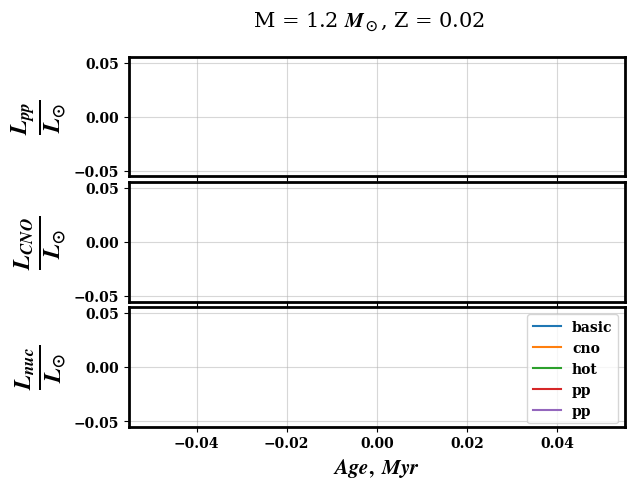

In [22]:
fig, axes = plt.subplots(nrows=3, ncols=1)
ax1 = axes[0]
ax2 = axes[1] 
ax3 = axes[2]

M_sample = [1.2, 2.2]
Z_sample = [0.001, 0.026]
V_sample = [0, 18]
nets_sample = ['basic', 'cno_extras', 'hot_cno', 'pp_and_cno_extras', 'pp_extras']

k = 1
k *= 4
for i in range(0, len(nets_sample)):
    # i += k
    ax1.plot(age[i], 10**np.array(pp[i]), label=nets[i])
    ax2.plot(age[i], 10**np.array(cno[i]), label=nets[i])
    ax3.plot(age[i], 10**np.array(L_nuc[i]), label=nets[i])
ax1.set_ylabel(r'$\frac{L_{pp}}{L_{\odot}}$', fontsize=25)
ax2.set_ylabel(r'$\frac{L_{CNO}}{L_{\odot}}$', fontsize=25)
ax3.set_ylabel(r'$\frac{L_{nuc}}{L_{\odot}}$', fontsize=25)
plt.xlabel(r'$Age,\ Myr$', fontsize=15)
ax1.set_xticklabels([])
plt.subplots_adjust(wspace=0, hspace=0.05)
ax1.grid(alpha=0.5)
ax2.grid(alpha=0.5)
ax3.grid(alpha=0.5)
plt.legend()
fig.suptitle(f"M = {M[i]} $M_\odot$, Z = {0.02}", fontsize=15)
# ax1.set_xlim(6, 30)
# ax2.set_xlim(6, 30)
# ax3.set_xlim(6, 30)

# plt.savefig('pp_cno.png', dpi=300)

In [ ]:
get_evo_time(logs)